In [1]:
import scipy.io as sio
import os
import h5py
import numpy as np

C:\Users\mi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path = 'data'
train_file = os.path.join(path, 'train.mat')

In [3]:
def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [4]:
def get_label(index, hdf5_data):
    item = hdf5_data['digitStruct']['bbox'][index].item()
    label = hdf5_data[item]['label']
    return [hdf5_data[label.value[i].item()].value[0][0]
                  for i in range(len(label))] if len(label) > 1 else [label.value[0][0]]

In [5]:
labels_file = train_file
f = h5py.File(labels_file)

In [6]:
get_name(0, f)

'1.png'

In [7]:
get_label(0, f)

[1.0, 9.0]

In [8]:
print(len(f['digitStruct/name']))

33402


In [9]:
lens = np.array([len(get_label(i, f)) for i in range(len(f['digitStruct/name']))])

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
counts = np.unique(lens, return_counts=True)

<BarContainer object of 6 artists>

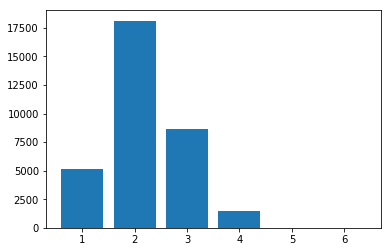

In [12]:
plt.bar(counts[0], counts[1])

<BarContainer object of 5 artists>

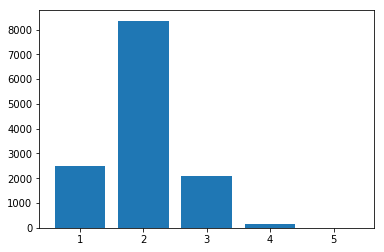

In [13]:
test = os.path.join(path, 'test.mat')
test_data = h5py.File(test)
test_lens = np.array([len(get_label(i, test_data)) for i in range(len(test_data['digitStruct/name']))])
test_counts = np.unique(test_lens, return_counts=True)
plt.bar(test_counts[0], test_counts[1])

In [9]:
from IPython import display
import cv2
import numpy as np
def sample_images(nrow, ncol, h_data, data_path):
        display.clear_output(wait=True)
        images = [cv2.imread(os.path.join(data_path, get_name(i, h_data))) 
                  for i in np.random.choice(range(len(h_data['/digitStruct/name'])), size=nrow * ncol)]
        for i in range(nrow * ncol):
            plt.subplot(nrow,ncol,i + 1)
            plt.imshow(images[i],cmap="gray", interpolation="none")
        plt.show()
    

In [10]:
train_path = os.path.join('data', 'train')
train_file = h5py.File(os.path.join('data', 'train.mat'))
sample_images(5, 5, train_file, train_path)

NameError: name 'plt' is not defined

In [16]:
test = os.path.join(path, 'test.mat')
test_data = h5py.File(test)
print(get_label(0, test_data))

[5.0]


In [6]:
from lib.dataset import HouseNumberTrainDataset

In [12]:
train_dataset = HouseNumberTrainDataset(train_path, os.path.join('data', 'train.mat'))
test_dataset = HouseNumberTrainDataset(os.path.join('data', 'test'), os.path.join('data', 'test.mat'))

In [34]:
from IPython import display
import cv2
import numpy as np
def sample_images_d(nrow, ncol, dataset):
        display.clear_output(wait=True)
        images = [dataset[i][0][0].permute(1, 2, 0).cpu().numpy()
                  for i in np.random.choice(range(len(dataset)), size=nrow * ncol)]
        for i in range(nrow * ncol):
            plt.subplot(nrow,ncol,i + 1)
            plt.imshow(images[i],cmap="gray", interpolation="none")
        plt.show()
    

In [36]:
img = train_dataset[0][0][0].permute(1, 2, 0).cpu().numpy()
print(img.max(), img.min())
# sample_images_d(5, 5, train_dataset)

1.0 0.02745098


In [19]:
from torchvision.models.resnet import resnet34
import torch
from catalyst.dl import SupervisedRunner
from torch.utils.data import DataLoader


In [20]:
model = resnet34(pretrained=True)
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 100),
                               torch.nn.Dropout(0.5),
                              torch.nn.Linear(100, 44)) 

In [ ]:
# experiment setup
logdir = "./logdir"
num_epochs = 42

# data
loaders = {"train": DataLoader(train_dataset, num_workers=1, batch_size=32), 
           "valid": DataLoader(test_dataset, num_workers=1, batch_size=32)}


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)


In [21]:
train_dataset[0]

(tensor([[[0.4235, 0.4078, 0.4392,  ..., 1.0000, 1.0000, 1.0000],
          [0.4941, 0.4706, 0.4588,  ..., 1.0000, 1.0000, 1.0000],
          [0.4706, 0.4902, 0.4667,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0667, 0.0706, 0.0902,  ..., 1.0000, 1.0000, 1.0000],
          [0.0784, 0.0706, 0.1137,  ..., 1.0000, 1.0000, 1.0000],
          [0.0784, 0.1098, 0.0941,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.4431, 0.4431, 0.4275,  ..., 1.0000, 1.0000, 1.0000],
          [0.4549, 0.4549, 0.4824,  ..., 1.0000, 1.0000, 1.0000],
          [0.4902, 0.4863, 0.4745,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0627, 0.0745, 0.0902,  ..., 1.0000, 1.0000, 1.0000],
          [0.0706, 0.0471, 0.0706,  ..., 1.0000, 1.0000, 1.0000],
          [0.0745, 0.0510, 0.0824,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.4314, 0.3922, 0.4353,  ..., 1.0000, 1.0000, 1.0000],
          [0.4549, 0.4510, 0.4588,  ..., 1.0000, 1.0000, 1.0000],
          [0.4824, 0.4588, 0.4431,  ...,

In [36]:
a = torch.zeros(1, len(train_dataset[0][1]), 12)
nums = torch.Tensor(train_dataset[0][1])
print(nums.shape)
starts = nums == -1
a[0][0][starts] = 1
a

torch.Size([4])


IndexError: The shape of the mask [4] at index 0 does not match the shape of the indexed tensor [12] at index 0